# 1. Install Dependencies

In [80]:
pip install pandas --upgrade

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import nltk
from nltk.probability import *
from itertools import chain
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Prepare and Explore data

## Preparation

In [4]:
# Path to data
base_path = "../../data/ISOT_Fake_News/"

fake_df = pd.read_csv(f"{base_path}Fake.csv")
true_df   = pd.read_csv(f"{base_path}True.csv")

In [5]:
print("fake data shape:", fake_df.shape)
print("true data shape:", true_df.shape)

fake data shape: (23481, 4)
true data shape: (21417, 4)


In [6]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
true_df['label'] = 1
fake_df['label'] = 0

In [9]:
# Combine fake and true
df = pd.concat([true_df, fake_df], ignore_index=True).sample(frac=1)

In [10]:
df.head()

,title,text,subject,date,label
4349,U.S. plans new sanctions for Syria in near fut...,"PALM BEACH, Fla. (Reuters) - U.S. Treasury Sec...",politicsNews,"April 7, 2017",1
15627,Hezbollah says Saudi Arabia forced Lebanese PM...,BEIRUT (Reuters) - Lebanon s Shi ite Hezbollah...,worldnews,"November 5, 2017",1
35496,BRILLIANT! LIBERAL SENATOR TRIES TO EMBARRASS ...,"Father Robert A. Sirico, President and Co-Foun...",politics,"Apr 19, 2016",0
24375,Tiffany Trump And Her Mother Just Tried To Ge...,"Freelancers love entitled people, really we do...",News,"January 18, 2017",0
19209,Australian Hindus protest meat advertisement f...,SYDNEY (Reuters) - Hundreds of people attended...,worldnews,"September 24, 2017",1


In [11]:
df['subject'].value_counts()

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

In [12]:
print("data shape:", df.shape)

data shape: (44898, 5)


In [13]:
df.duplicated().sum()

209

In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df.duplicated().sum()

0

In [16]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [17]:
empty_text_rows = df[df["text"].str.strip() == ""]

In [18]:
empty_text_rows

,title,text,subject,date,label
35380,POLL: Who Should Donald Trump Choose For Vice ...,,politics,"May 7, 2016",0
34535,KAINE GETS TRIPPED UP Trying To Explain Away H...,,politics,"Sep 1, 2016",0
37672,WOW! TUCKER CARLSON TAKES ON OBAMACARE ARCHITE...,,Government News,"Jan 26, 2017",0
34299,THIS WILL MAKE YOUR WEEK! Do You Want To Build...,,politics,"Sep 29, 2016",0
32747,BRILLIANT! TUCKER CARLSON and AYAAN HIRSI ALI ...,,politics,"Mar 22, 2017",0
...,...,...,...,...,...
40323,THE HORRIBLE END GAME: BERNIE SANDERS Calls fo...,,left-news,"Mar 26, 2017",0
37081,(VIDEO) JUDGE NAPOLITANO FILLS US IN ON ORDER ...,,politics,"May 20, 2015",0
33505,MTV Releases Racist ‘Hey Fellow White Guy’s Vi...,,politics,"Dec 21, 2016",0
32820,KIMBERLY GUILFOYLE: Serious Legal Issues Surro...,,politics,"Mar 15, 2017",0


In [19]:
# Remove empty texts
df = df[df["text"].str.strip() != ""]

## Exploration

In [21]:
group = df.groupby(['subject', 'label']).size().reset_index(name='count')
group

,subject,label,count
0,Government News,0,1498
1,Middle-east,0,778
2,News,0,9050
3,US_News,0,783
4,left-news,0,4309
5,politics,0,6430
6,politicsNews,1,11219
7,worldnews,1,9991


<Axes: xlabel='subject', ylabel='count'>

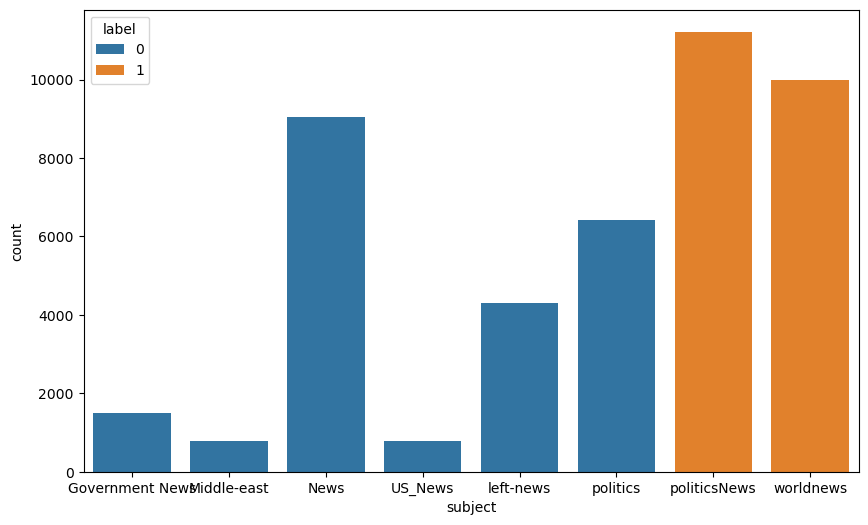

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(group, x='subject', y='count', hue='label')

# 3. Text cleaning

## Lowercase all text

In [44]:
import re

In [46]:
def lowerStringCols(df):
    for col in df.columns:
        if df[col].dtype == "O": # If column data type is an object
            df[col] = df[col].str.lower()
    return df

In [48]:
df = lowerStringCols(df)

In [49]:
# Extract columns
df_text = df['text']
df_title = df['title']

In [50]:
df_title.iloc[0]

"u.s. plans new sanctions for syria in near future: treasury's mnuchin"

In [54]:
df_text.iloc[0]

'palm beach, fla. (reuters) - u.s. treasury secretary steve mnuchin on friday told reporters that he plans to announce additional economic sanctions aimed at syria in the near future, part of the u.s. response to a poison gas attack that western countries say was carried out by the government of syrian president bashar al-assad. “we expect that those (sanctions) will continue to have an important effect on preventing people from doing business with them,” mnuchin said. “these sanctions are very important and we will use them the maximum effect.” '

## Remove URL and Picture links

In [57]:
df_text.iloc[9]

' a cesspool of corruption    newt gingrich calls out attorney general jeff sessions. he says it s time for sessions to  step up  to the plate. we couldn t agree more!the latest dirt to come out on the fbi:sean hannity interviewed greg jarrett, judicial watch s tom fitton and the amazing sara carter last night it was fireworks on what s being exposed:sara carter speaks up at the 3:30 point but the entire video is well worth watching:we were told yesterday that  the fix was in in so many ways, this is beyond corrupt and is blatant criminality by the intel agencies, hillary clinton and the obama administration.it s  worse than you even know    tom fitton the fix was in watered down document clears clinton:the interview below is pretty much what we all knew but now it s out in the open. notice how senator johnson calls on the doj to act:senator ron johnson told tucker carlson tonight that the corruption in the intel agencies is much worse that we thought. he believes that the entire inves

In [59]:
def removeURLandPic(text):
    regex = re.compile('https?://\S+|www\.\S+|pic\.twitter\.com/\S+')
    text = regex.sub('', text)
    return text

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
C:\Users\yanni\AppData\Local\Temp\ipykernel_23772\3147657975.py:2: SyntaxWarning: invalid escape sequence '\S'
  regex = re.compile('https?://\S+|www\.\S+|pic\.twitter\.com/\S+')


In [61]:
df_title = df_title.apply(lambda x: removeURLandPic(x))
df_text = df_text.apply(lambda x:  removeURLandPic(x))

In [62]:
df_text.iloc[9]

' a cesspool of corruption    newt gingrich calls out attorney general jeff sessions. he says it s time for sessions to  step up  to the plate. we couldn t agree more!the latest dirt to come out on the fbi:sean hannity interviewed greg jarrett, judicial watch s tom fitton and the amazing sara carter last night it was fireworks on what s being exposed:sara carter speaks up at the 3:30 point but the entire video is well worth watching:we were told yesterday that  the fix was in in so many ways, this is beyond corrupt and is blatant criminality by the intel agencies, hillary clinton and the obama administration.it s  worse than you even know    tom fitton the fix was in watered down document clears clinton:the interview below is pretty much what we all knew but now it s out in the open. notice how senator johnson calls on the doj to act:senator ron johnson told tucker carlson tonight that the corruption in the intel agencies is much worse that we thought. he believes that the entire inves

## Remove HTML

In [66]:
from bs4 import BeautifulSoup

# Check for HTML in texts
title_has_html = df_title.apply(lambda x: bool(BeautifulSoup(x, "html.parser").find()))
text_has_html = df_text.apply(lambda x: bool(BeautifulSoup(x, "html.parser").find()))

C:\Users\yanni\AppData\Local\Temp\ipykernel_23772\2007566370.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  title_has_html = df_title.apply(lambda x: bool(BeautifulSoup(x, "html.parser").find()))
C:\Users\yanni\AppData\Local\Temp\ipykernel_23772\2007566370.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text_has_html = df_text.apply(lambda x: bool(BeautifulSoup(x, "html.parser").find()))


In [67]:
title_has_html.sum()

0

In [68]:
text_has_html.sum()

37

In [69]:
def removeHTML(text):
    # Use beautifulSoup to remove simple HTML code
    text = BeautifulSoup(text, "html.parser").get_text()
    # HTML like < /script> slip past BeautifulSoup
    regex = re.compile('<[^>]+>')
    text = regex.sub('', text)
    return text

In [70]:
# Remove HTML
df_title = df_title.apply(lambda x: removeHTML(x))
df_text = df_text.apply(lambda x: removeHTML(x))

C:\Users\yanni\AppData\Local\Temp\ipykernel_23772\2353583764.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [71]:
# Check
text_has_html = df_text.apply(lambda x: bool(BeautifulSoup(x, "html.parser").find()))
text_has_html.sum()

C:\Users\yanni\AppData\Local\Temp\ipykernel_23772\1801346838.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text_has_html = df_text.apply(lambda x: bool(BeautifulSoup(x, "html.parser").find()))


0

## Remove extra whitespaces

In [79]:
def removeExtraWhitespaces(text):
    regex = re.compile('\s+')
    text = regex.sub(' ', text)
    return text

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\yanni\AppData\Local\Temp\ipykernel_23772\1438173248.py:2: SyntaxWarning: invalid escape sequence '\s'
  regex = re.compile('\s+')


In [81]:
df_title = df_title.apply(lambda x: removeExtraWhitespaces(x))
df_text = df_text.apply(lambda x:  removeExtraWhitespaces(x))

# 4. Tokenize

In [83]:
def tokenize(text):
    pattern = r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?"
    tokenizer = nltk.RegexpTokenizer(pattern) 
    tokenized_text = tokenizer.tokenize(text)
    return tokenized_text

In [84]:
token_df_title = df_title.apply(lambda x: tokenize(x))
token_df_text = df_text.apply(lambda x: tokenize(x))

In [85]:
token_df_text

4349     [palm, beach, fla, reuters, u, s, treasury, se...
15627    [beirut, reuters, lebanon, s, shi, ite, hezbol...
35496    [father, robert, a, sirico, president, and, co...
24375    [freelancers, love, entitled, people, really, ...
19209    [sydney, reuters, hundreds, of, people, attend...
                               ...                        
37116    [just, like, hillary, stephanopoulos, claims, ...
19666    [london, reuters, british, prime, minister, th...
43778    [by, brandon, turbevillecnn, is, in, full, pan...
32360    [according, to, the, journal, of, blacks, in, ...
36942    [a, defender, of, the, confederate, flag, who,...
Name: text, Length: 44058, dtype: object

In [86]:
token_df_title

4349     [u, s, plans, new, sanctions, for, syria, in, ...
15627    [hezbollah, says, saudi, arabia, forced, leban...
35496    [brilliant, liberal, senator, tries, to, embar...
24375    [tiffany, trump, and, her, mother, just, tried...
19209    [australian, hindus, protest, meat, advertisem...
                               ...                        
37116    [busted, the, oh, so, objective, abc, news, ch...
19666    [uk's, may, says, foreign, minister, johnson, ...
43778    [cnn, in, a, panic, over, assad, success, coll...
32360    [black, harvard, students, host, separate, seg...
36942    [breaking, obama, s, race, war, part, ii, braw...
Name: title, Length: 44058, dtype: object

## Remove single char Tokens

In [93]:
def removeSingleCharTokens(text):
    for i in text:
        if len(i) == 1:
            text.remove(i)
    
    return text

In [95]:
token_df_title = token_df_title.apply(lambda x: removeSingleCharTokens(x))
token_df_text = token_df_text.apply(lambda x: removeSingleCharTokens(x))

In [96]:
token_df_title

4349     [s, plans, new, sanctions, for, syria, in, nea...
15627    [hezbollah, says, saudi, arabia, forced, leban...
35496    [brilliant, liberal, senator, tries, to, embar...
24375    [tiffany, trump, and, her, mother, just, tried...
19209    [australian, hindus, protest, meat, advertisem...
                               ...                        
37116    [busted, the, oh, so, objective, abc, news, ch...
19666    [uk's, may, says, foreign, minister, johnson, ...
43778    [cnn, in, panic, over, assad, success, collaps...
32360    [black, harvard, students, host, separate, seg...
36942    [breaking, obama, race, war, part, ii, brawl, ...
Name: title, Length: 44058, dtype: object

## Remove stop words

In [100]:
# Create stop words list
stop_words = []

with open("stopwords-en.txt", "r", encoding="utf-8") as file:
    for word in file:
        # Remove /n from the word
        word = word.strip()
        
        stop_words.append(word)

In [102]:
stop_words

["'ll",
 "'tis",
 "'twas",
 "'ve",
 '10',
 '39',
 'a',
 "a's",
 'able',
 'ableabout',
 'about',
 'above',
 'abroad',
 'abst',
 'accordance',
 'according',
 'accordingly',
 'across',
 'act',
 'actually',
 'ad',
 'added',
 'adj',
 'adopted',
 'ae',
 'af',
 'affected',
 'affecting',
 'affects',
 'after',
 'afterwards',
 'ag',
 'again',
 'against',
 'ago',
 'ah',
 'ahead',
 'ai',
 "ain't",
 'aint',
 'al',
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'alongside',
 'already',
 'also',
 'although',
 'always',
 'am',
 'amid',
 'amidst',
 'among',
 'amongst',
 'amoungst',
 'amount',
 'an',
 'and',
 'announce',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anymore',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'ao',
 'apart',
 'apparently',
 'appear',
 'appreciate',
 'appropriate',
 'approximately',
 'aq',
 'ar',
 'are',
 'area',
 'areas',
 'aren',
 "aren't",
 'arent',
 'arise',
 'around',
 'arpa',
 'as',
 'aside',
 'ask',
 'asked',
 'asking',
 'asks',
 'associated

In [104]:
def removeStopWords(text):
    
    text = [token for token in text if token not in stop_words]
    
    return text

In [106]:
token_df_title = token_df_title.apply(lambda x: removeStopWords(x))
token_df_text = token_df_text.apply(lambda x: removeStopWords(x))

In [107]:
token_df_title

4349     [plans, sanctions, syria, future, treasury's, ...
15627    [hezbollah, saudi, arabia, forced, lebanese, q...
35496    [brilliant, liberal, senator, embarrass, pries...
24375    [tiffany, trump, mother, expensive, service, r...
19209    [australian, hindus, protest, meat, advertisem...
                               ...                        
37116    [busted, objective, abc, news, chief, anchor, ...
19666                   [uk's, foreign, minister, johnson]
43778    [cnn, panic, assad, success, collapse, white, ...
32360    [black, harvard, students, host, separate, seg...
36942    [breaking, obama, race, war, brawl, breaks, st...
Name: title, Length: 44058, dtype: object

# 5. Create cleaned excel

In [111]:
# Return data back to its db
df['title'] = token_df_title
df['text'] = token_df_text

In [113]:
df['title'] = df['title'].apply(lambda x: ' '.join(x))
df['text'] = df['text'].apply(lambda x: ' '.join(x))

In [115]:
df

,title,text,subject,date,label
4349,plans sanctions syria future treasury's mnuchin,palm beach fla reuters treasury secretary stev...,politicsnews,"april 7, 2017",1
15627,hezbollah saudi arabia forced lebanese quit,beirut reuters lebanon shi ite hezbollah sunda...,worldnews,"november 5, 2017",1
35496,brilliant liberal senator embarrass priest sch...,father robert sirico president co-founder acto...,politics,"apr 19, 2016",0
24375,tiffany trump mother expensive service rich,freelancers love entitled people entitled peop...,news,"january 18, 2017",0
19209,australian hindus protest meat advertisement f...,sydney reuters hundreds people attended rallie...,worldnews,"september 24, 2017",1
...,...,...,...,...,...
37116,busted objective abc news chief anchor george ...,hillary stephanopoulos claims honest mistake d...,politics,"may 14, 2015",0
19666,uk's foreign minister johnson,london reuters british prime minister theresa ...,worldnews,"september 19, 2017",1
43778,cnn panic assad success collapse white helmets...,brandon turbevillecnn panic mode resumption sy...,us_news,"november 19, 2016",0
32360,black harvard students host separate segregate...,journal blacks education marks harvard percent...,politics,"may 8, 2017",0


In [119]:
df.to_excel("cleaned_ISOT_data.xlsx")